In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense

In [5]:
# Path ke file dataset Anda di Kaggle
file_path = '/kaggle/input/fake-news/FakeNewsNet.csv'

# Kolom yang akan digunakan: 'title' untuk teks, 'real' untuk label
KOLOM_TEKS = 'title'
KOLOM_LABEL = 'real'

# Membaca dataset
df = pd.read_csv(file_path)

# Mengambil kolom yang dibutuhkan dan membersihkan data yang kosong
df_clean = df[[KOLOM_TEKS, KOLOM_LABEL]].dropna()

# Memastikan tipe data label adalah angka (integer)
df_clean[KOLOM_LABEL] = df_clean[KOLOM_LABEL].astype(int)

# Mengambil sampel 100 berita asli (real=1) dan 100 berita palsu (real=0)
real_news = df_clean[df_clean[KOLOM_LABEL] == 1].sample(n=100, random_state=42)
fake_news = df_clean[df_clean[KOLOM_LABEL] == 0].sample(n=100, random_state=42)

# Menggabungkan kedua sampel dan mengacak urutannya
data = pd.concat([real_news, fake_news]).sample(frac=1, random_state=42).reset_index(drop=True)

# Menampilkan 5 data pertama untuk memastikan data sudah benar
print("Data siap digunakan:")
data.head()

Data siap digunakan:


,title,real
0,Watch Erika Jayne’s Unexpected—And Unforgettab...,1
1,John Goodman Is Back! How Roseanne Revival Exp...,1
2,People's Choice Awards,1
3,Pregnant Miranda Kerr has reportedly already s...,0
4,... Response to: Chris Brown Gets FOUR New Car...,0


In [7]:
### Sel 3: Pra-pemrosesan Teks (Tokenisasi & Padding)

# Hanya berjalan jika data berhasil dimuat
if data is not None:
    # Mengambil teks judul dan label dari dataframe
    texts = data[KOLOM_TEKS].values
    labels = data[KOLOM_LABEL].values # Data label disimpan di variabel 'labels'

    # Inisialisasi Tokenizer, hanya 5000 kata paling umum yang akan digunakan
    tokenizer = Tokenizer(num_words=5000)
    tokenizer.fit_on_texts(texts)

    # Mengubah teks menjadi urutan angka (sequences)
    X = tokenizer.texts_to_sequences(texts)

    # Menyamakan panjang semua urutan menjadi 50 token (padding)
    X = pad_sequences(X, maxlen=50)

    # --- PERBAIKAN: Menggunakan variabel 'labels' yang benar, bukan 'y' ---
    X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

    print(f"Jumlah data latih: {len(X_train)}")
    print(f"Jumlah data uji: {len(X_test)}")

Jumlah data latih: 160
Jumlah data uji: 40


In [8]:
# Membuat model Sequential
model = Sequential()

# Lapisan Embedding: Mengubah indeks kata menjadi vektor representasi kata
model.add(Embedding(input_dim=5000, output_dim=64))

# Lapisan LSTM: Lapisan utama untuk memproses data sekuensial
model.add(LSTM(64))

# Lapisan Output: Menggunakan aktivasi 'sigmoid' untuk klasifikasi biner
model.add(Dense(1, activation='sigmoid'))

# Kompilasi model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Menampilkan ringkasan arsitektur model
model.summary()

# Melatih model
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=16,
                    validation_split=0.2, # Menggunakan 20% data latih untuk validasi
                    verbose=1)

I0000 00:00:1752412204.923052      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


I0000 00:00:1752412208.456468     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.4093 - loss: 0.6944 - val_accuracy: 0.4062 - val_loss: 0.6950
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5714 - loss: 0.6872 - val_accuracy: 0.3750 - val_loss: 0.6990
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5918 - loss: 0.6735 - val_accuracy: 0.3750 - val_loss: 0.7096
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6988 - loss: 0.6356 - val_accuracy: 0.5625 - val_loss: 0.7223
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7773 - loss: 0.5554 - val_accuracy: 0.5312 - val_loss: 0.6724
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9827 - loss: 0.4864 - val_accuracy: 0.6250 - val_loss: 0.6518
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9868 - loss: 0.3669 - val_accuracy: 0.5938 - val_loss: 0.6425
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9467 - loss: 0.2059 - val_accuracy: 0.5625 - val_loss: 0.6861
Epoch 9/10



Akurasi pada data uji: 42.50%



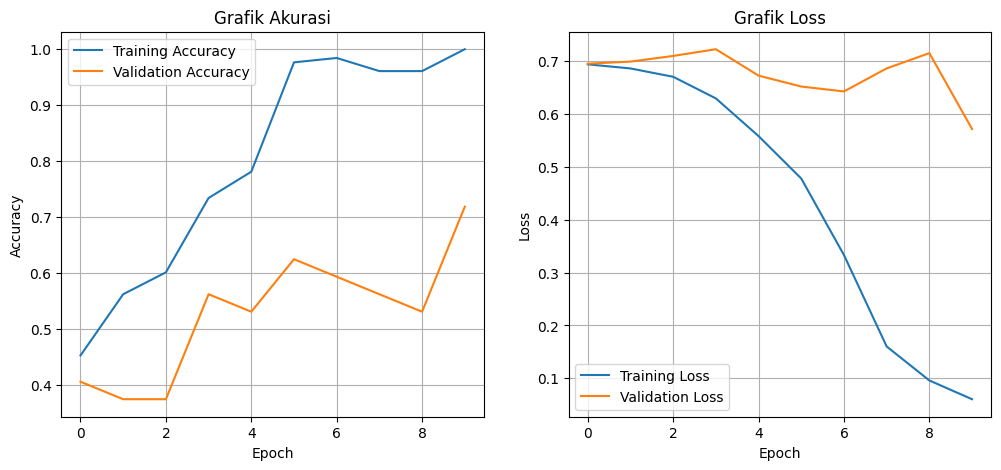

In [9]:
# Mengevaluasi performa model pada data uji
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"\nAkurasi pada data uji: {accuracy*100:.2f}%\n")


# Visualisasi Akurasi Training vs Validasi
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Grafik Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Visualisasi Loss Training vs Validasi
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Grafik Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

### 📌 Penutup dan Refleksi

### 🔍 Kesimpulan
Pada tugas ini, saya membangun model klasifikasi teks menggunakan arsitektur **Long Short-Term Memory (LSTM)** untuk memisahkan **berita asli (real)** dan **berita palsu (fake)**. Dataset terdiri dari 200 judul berita (100 asli, 100 palsu) yang diambil dari `FakeNewsNet.csv`, kemudian diproses dan dipelajari oleh model secara bertahap.

Hasil dari eksperimen menunjukkan **performa yang tidak memuaskan**. Model yang dilatih hanya mampu mencapai:
* Akurasi pada data uji sebesar **42.50%**.
* Nilai ini lebih rendah dari tebakan acak (50%), yang mengindikasikan bahwa model **gagal mempelajari pola** yang membedakan kedua kelas berita.
* Grafik *loss* dan akurasi selama pelatihan juga menunjukkan performa yang tidak stabil dan tidak ada tanda-tanda konvergensi (proses belajar yang baik).

Ini menunjukkan bahwa dengan konfigurasi saat ini, model LSTM **tidak mampu** menggeneralisasi pengetahuan dari data latih yang sangat terbatas.

---

### ✨ Refleksi Proses
Beberapa hal penting yang saya pelajari dari hasil yang didapat:

* **Kuantitas Data adalah Kunci:** Penyebab utama kegagalan model ini adalah **jumlah data yang sangat terbatas** (200 sampel). Model *deep learning* seperti LSTM membutuhkan ribuan contoh untuk dapat belajar secara efektif. Dengan data yang minim, model justru "bingung" dan tidak bisa belajar.
* **Input yang Terlalu Ringkas:** Menggunakan **judul berita** saja, yang notabene sangat pendek, memberikan sinyal yang terlalu lemah bagi model, terutama saat jumlah datanya sedikit.
* **Pelajaran dari Kegagalan:** Kegagalan ini memberikan pelajaran penting bahwa **kualitas dan kuantitas data adalah fondasi utama** dalam *machine learning*. Arsitektur model yang canggih tidak akan berguna jika data yang diberikan tidak memadai.

---

### 💡 Rencana Pengembangan Selanjutnya
Berdasarkan analisis kegagalan, langkah perbaikan yang paling prioritas adalah:

* **Menambah Jumlah Data (Prioritas Utama):** Meningkatkan jumlah sampel data secara drastis (misalnya, menjadi 2000 data, 1000 per kelas) adalah langkah pertama dan terpenting yang harus dilakukan.
* **Menggunakan Konten Penuh:** Menggunakan **seluruh isi berita (`text`)** sebagai input, bukan hanya judul, untuk memberikan konteks yang jauh lebih kaya kepada model.
* **Menyederhanakan Model:** Mencoba arsitektur yang lebih sederhana atau model klasik (seperti Naive Bayes) yang mungkin lebih cocok untuk dataset berukuran kecil.
* **Tuning Hyperparameter:** Jika data sudah ditambah, melakukan eksperimen dengan `learning rate`, `batch size`, atau jumlah unit LSTM yang berbeda.

---

### 🙏 Penutup
Meskipun model pada percobaan awal ini tidak mencapai akurasi yang diharapkan, tugas ini memberikan pengalaman yang sangat berharga tentang pentingnya **analisis data dan proses *debugging*** dalam *machine learning*. Memahami mengapa sebuah model gagal adalah bagian fundamental dari siklus pengembangan, yang mengarahkan pada identifikasi masalah dan solusi perbaikan yang lebih terarah dan efektif.